In [67]:
from typing import List
from models.hivt_visualize import SeqTrajectorySet
import pickle
predictions: List[SeqTrajectorySet] = pickle.load(open("predictions_for_visualize.pkl", "rb"))

In [68]:
origin

tensor([2169.5208,  821.1721])

In [2]:
from argoverse.map_representation.map_api import ArgoverseMap

import numpy as np
import pandas as pd
d = pd.read_csv("../argoverse-dataset-sample/test_obs/data/3700.csv")

In [1]:
import torch
t = torch.load("../argoverse-dataset-sample/test_obs/processed/3700.pt")

In [48]:
print(f"{t.positions.shape=}")
print(f"{t.x.shape=}")
print(f"{t.lane_vectors.shape=}")
print(f"{t.rotate_angles.shape=}")

t.positions.shape=torch.Size([23, 50, 2])
t.x.shape=torch.Size([23, 20, 2])
t.lane_vectors.shape=torch.Size([981, 2])
t.rotate_angles.shape=torch.Size([23])


In [108]:
weights = [1.2295e-03, 4.1246e-07, 4.1246e-07, 4.1246e-07, 2.2520e-05, 4.9603e-01,
        4.1246e-07, 4.1246e-07, 1.5174e-07, 1.1212e-06, 3.3422e-03, 1.1212e-06,
        3.3422e-03, 4.9603e-01, 1.5174e-07, 1.5174e-07, 1.5174e-07, 1.5174e-07,
        1.5174e-07, 1.1212e-06, 1.5174e-07, 4.1246e-07, 1.1212e-06]

In [103]:
def get_svg_trajectories(rotated_predictions, rotated_positions, predictions,*, agent_index, av_index, width=4, height=2):
    trajectory_tags = []
    
    for node_index, (node_traj, node_positions) in enumerate(zip(rotated_predictions, rotated_positions)):
        node_origin = node_positions[0]
        # if node_index == agent_index or node_index == av_index:
        for mode_i, mode in enumerate(node_traj):
            probability = predictions.nodes_traj[node_index].modes[mode_i].probability
            for x, y in mode:
                trajectory_tags.append(
                    f"""
                    <circle cx="{x + node_origin[0]}" cy="{y + node_origin[1]}" r="0.3" fill="hsl(210, 100%, {100 - probability*100 * 2}%)" />
                    """
                )
    return trajectory_tags

In [107]:
def get_svg_rectangles(positions, angles, nodes_weight, *, av_index, agent_index, width=4, height=2):
    rect_tags = []
    color_dict = {agent_index: "red", av_index:"blue"}
    for i, ((x, y), angle) in enumerate(zip(positions[:, 0, :], angles)):
        rect_tag = f"""<rect x="{x - width/2}" y="{y - height/2}"
                                width="{width}" height="{height}"
                                stroke="black" stroke-width="{0.1 + nodes_weight[i] * 0.5}"
                                fill="{color_dict.get(i, 'transparent')}"
                                transform="rotate({-angle * 57.2958}, {x}, {y})"/>"""
        rect_tags.append(rect_tag)
    return rect_tags

In [59]:
def get_svg_centerlines(rotated_positions, origin, city: str, ) -> list:
    avm = ArgoverseMap()
    seq_lane_props = avm.city_lane_centerlines_dict[city]

    x_max = rotated_positions[:, :, 0].max()
    x_min = rotated_positions[:, :, 0].min()
    y_max = rotated_positions[:, :, 1].max()
    y_min = rotated_positions[:, :, 1].min()


    lane_centerlines = []
    # Get lane centerlines which lie within the range of trajectories
    for lane_id, lane_props in seq_lane_props.items():

        lane_cl = lane_props.centerline

        if (
            np.min(lane_cl[:, 0]) - origin[0]< x_max
            and np.min(lane_cl[:, 1]) - origin[1] < y_max
            and np.max(lane_cl[:, 0]) - origin[0] > x_min
            and np.max(lane_cl[:, 1]) - origin[1] > y_min
        ):
            lane_centerlines.append(np.array([lane_cl[:, 0] - origin[0], lane_cl[:, 1] - origin[1]]))
    
    centerline_tags = []
    for lane_cl in lane_centerlines:
        centerline_tag = f"""<polyline points="{','.join([f'{x},{y}' for x, y in zip(lane_cl[0], lane_cl[1])])}"
                                        style="fill:none;stroke:black;stroke-width:0.1"/>"""
        centerline_tags.append(centerline_tag)
    return centerline_tags

In [113]:
def draw_canvas_to_svg(data, predictions) -> str:
    theta = data.theta
    rotation_mat = torch.tensor(
                [
                    [torch.cos(theta), -torch.sin(theta)],
                    [torch.sin(theta), torch.cos(theta)],
                ]
            )
    rotated_positions = data.positions @ rotation_mat.inverse()
    rotated_predictions = predictions.tensor @ rotation_mat.inverse()

    rotate_angles = (data.rotate_angles - theta)

    canvas_size = abs(rotated_positions.max() - rotated_positions.min())
    html_template = """<svg xmlns="http://www.w3.org/2000/svg" version="1.1" width="800" height="800" viewBox="{min_x} {min_y} {canvas_width} {canvas_height}">
    {trajectories}
    {centerlines}
    {rects}
    </svg>
    """.format(
        min_x=rotated_positions.min() - canvas_size*0.1,
        min_y=rotated_positions.min()- canvas_size*0.1,
        canvas_width=canvas_size* 1.2,
        canvas_height=canvas_size * 1.2,
        rects="\n".join(get_svg_rectangles(rotated_positions, rotate_angles, weights, av_index=data.av_index, agent_index=data.agent_index)),
        centerlines="\n".join(get_svg_centerlines(rotated_positions, data.origin[0].numpy(), data.city)),
        trajectories="\n".join(get_svg_trajectories(rotated_predictions, rotated_positions, predictions, av_index=data.av_index, agent_index=data.agent_index)),
    )
    return html_template

from IPython.core.display import HTML
html = draw_canvas_to_svg(t, predictions[0])
HTML(html)

In [55]:
theta = t.theta
rotation_mat = torch.tensor(
            [
                [torch.cos(theta), -torch.sin(theta)],
                [torch.sin(theta), torch.cos(theta)],
            ]
        )
rotated_positions = torch.mm(first_positions, rotation_mat.inverse())

NameError: name 'first_positions' is not defined

In [108]:
(t.positions @ rotation_mat.inverse())[:,0,:]

tensor([[ 7.6172e-02,  7.6721e-02],
        [ 1.7839e+01,  1.9421e+01],
        [ 1.1956e+01,  1.4874e+01],
        [ 1.0839e+01,  6.5851e+00],
        [ 7.0762e+00,  1.1432e+01],
        [ 3.1714e+00, -5.1301e+01],
        [-8.4250e+00, -2.1859e+00],
        [ 2.2749e+01,  2.3459e+01],
        [ 2.0524e+01,  1.8108e+01],
        [-1.7921e+01, -2.1537e+01],
        [-1.4244e+01, -6.3202e+00],
        [-8.2443e+01, -5.9113e+01],
        [ 5.3161e+01,  4.1729e+01],
        [ 1.9382e+01,  1.7116e+01],
        [-3.7073e+00,  2.6753e+00],
        [ 2.4543e+01,  1.7763e+01],
        [ 1.3796e+00,  7.2474e+00],
        [ 1.8169e+01,  1.3317e+01],
        [ 7.8113e+00,  1.5957e+01],
        [ 1.3664e+01,  2.0311e+01],
        [-9.0837e+00, -8.0672e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00]])

In [82]:
first_positions.shape

torch.Size([23, 2])

In [83]:
rotation_mat.shape

torch.Size([2, 2])

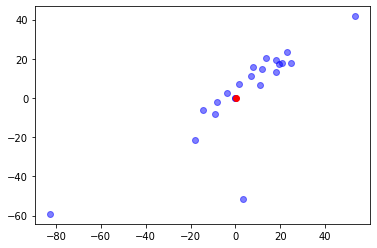

In [87]:
import matplotlib.pyplot as plt

plt.plot(
            rotated_positions[1:,0],
            rotated_positions[1:,1],
            "o",
            color="blue",
            alpha=0.5,
            linewidth=0.1,
        )
plt.plot(
            rotated_positions[0,0],
            rotated_positions[0,1],
            "o",
            color="red",
            alpha=1,
            linewidth=0.1,
        )


In [88]:
rotated_positions

tensor([[ 7.6172e-02,  7.6721e-02],
        [ 1.7839e+01,  1.9421e+01],
        [ 1.1956e+01,  1.4874e+01],
        [ 1.0839e+01,  6.5851e+00],
        [ 7.0762e+00,  1.1432e+01],
        [ 3.1714e+00, -5.1301e+01],
        [-8.4250e+00, -2.1859e+00],
        [ 2.2749e+01,  2.3459e+01],
        [ 2.0524e+01,  1.8108e+01],
        [-1.7921e+01, -2.1537e+01],
        [-1.4244e+01, -6.3202e+00],
        [-8.2443e+01, -5.9113e+01],
        [ 5.3161e+01,  4.1729e+01],
        [ 1.9382e+01,  1.7116e+01],
        [-3.7073e+00,  2.6753e+00],
        [ 2.4543e+01,  1.7763e+01],
        [ 1.3796e+00,  7.2474e+00],
        [ 1.8169e+01,  1.3317e+01],
        [ 7.8113e+00,  1.5957e+01],
        [ 1.3664e+01,  2.0311e+01],
        [-9.0837e+00, -8.0672e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00]])

In [91]:
xs = rotated_positions[:,0].numpy()

In [94]:
xs = list(xs)
xs.sort()
print(xs)

[-82.442635, -17.9209, -14.244142, -9.083741, -8.425049, -3.7072756, 0.0, 0.0, 0.076171875, 1.3796389, 3.1713853, 7.076172, 7.8112793, 10.839355, 11.9563, 13.664308, 17.838867, 18.169191, 19.381836, 20.524416, 22.74878, 24.542969, 53.16089]


In [149]:
canvas_size = abs(rotated_positions.max() - rotated_positions.min())
html_template = """<svg xmlns="http://www.w3.org/2000/svg" version="1.1" width="800" height="800" viewBox="{min_x} {min_y} {canvas_width} {canvas_height}">
{centerlines}
</svg>
""".format(
    min_x=rotated_positions.min() - canvas_size*0.1,
    min_y=rotated_positions.min()- canvas_size*0.1,
    canvas_width=canvas_size* 1.2,
    canvas_height=canvas_size * 1.2,
    centerlines="\n".join(get_svg_centerlines(lane_centerlines)),
)

from IPython.core.display import HTML
HTML(html_template)

In [104]:
theta = t.theta
rotation_mat = torch.tensor(
            [
                [torch.cos(theta), -torch.sin(theta)],
                [torch.sin(theta), torch.cos(theta)],
            ]
        )
rotated_positions = t.positions @ rotation_mat.inverse()
rotated_predictions = predictions[0].tensor @ rotation_mat.inverse()

canvas_size = abs(rotated_positions.max() - rotated_positions.min())
html_template = """<svg xmlns="http://www.w3.org/2000/svg" version="1.1" width="800" height="800" viewBox="{min_x} {min_y} {canvas_width} {canvas_height}">
{trajectories}
</svg>
""".format(
    min_x=rotated_positions.min() - canvas_size*0.1,
    min_y=rotated_positions.min()- canvas_size*0.1,
    canvas_width=canvas_size* 1.2,
    canvas_height=canvas_size * 1.2,
    trajectories="\n".join(get_svg_trajectories(rotated_predictions, rotated_positions,predictions[0], agent_index=t.agent_index, av_index=t.av_index)),
)

from IPython.core.display import HTML
HTML(html_template)

In [88]:
rotated_predictions[t.agent_index][:,:,0].shape

torch.Size([6, 30])

In [85]:
t.positions[t.agent_index]

tensor([[14.1830, -6.4563],
        [14.2538, -6.4760],
        [14.3311, -6.4867],
        [14.3693, -6.4995],
        [14.4588, -6.4918],
        [14.5499, -6.4988],
        [14.6320, -6.5190],
        [14.7077, -6.5138],
        [14.8516, -6.5404],
        [14.9805, -6.5469],
        [15.1538, -6.5559],
        [15.3056, -6.5860],
        [15.4959, -6.6028],
        [15.6711, -6.6213],
        [15.8763, -6.6157],
        [16.1180, -6.6590],
        [16.4406, -6.7500],
        [16.6852, -6.7728],
        [16.9570, -6.8051],
        [17.2971, -6.8245],
        [17.6172, -6.8788],
        [18.0214, -6.9744],
        [18.3291, -6.9614],
        [19.2034, -7.0505],
        [19.5895, -7.0518],
        [20.0318, -7.0838],
        [20.5593, -7.1568],
        [21.1111, -7.2582],
        [21.5473, -7.2646],
        [22.0119, -7.2965],
        [22.5629, -7.3891],
        [23.0705, -7.4220],
        [23.5699, -7.5099],
        [24.1834, -7.5836],
        [24.8750, -7.6806],
        [25.4172, -7